In [19]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

CSV_PATH = "../../datasets/students_simple.csv"

N = 8
idx1 = N % 5                
idx2 = (N**2) % 5 + 5

print(f"N = {N}")
print(f"Columns indexes: {idx1} и {idx2}")

N = 8
Columns indexes: 3 и 9


In [20]:
try:
    df_raw = pd.read_csv(CSV_PATH)
except FileNotFoundError as e:
    raise FileNotFoundError(
        f"Not found file {CSV_PATH}."
    ) from e

print("Shape:", df_raw.shape)
display(df_raw.head())

n_cols = df_raw.shape[1]
need_cols = max(idx1, idx2)

if n_cols < need_cols:
    raise ValueError(
        f"Not enough columns in the dataset"
    )

colname_x = df_raw.columns[idx1]
colname_y = df_raw.columns[idx2]

df_xy = df_raw.iloc[:, [idx1, idx2]].copy()
df_xy.columns = ["X_raw", "Y_raw"]

df_xy["X"] = pd.to_numeric(df_xy["X_raw"], errors="coerce")
df_xy["Y"] = pd.to_numeric(df_xy["Y_raw"], errors="coerce")

df_xy = df_xy.dropna(subset=["X", "Y"]).copy()

print(f"Columns: X = '{colname_x}', Y = '{colname_y}'")
print("Number of observations after cleaning:", len(df_xy))
display(df_xy[["X", "Y"]].head())

Shape: (20, 10)


,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


Columns: X = 'iq', Y = 'test_time'
Number of observations after cleaning: 20


,X,Y
0,95,8.5
1,115,6.2
2,111,6.8
3,97,12.0
4,105,7.5


In [21]:
desc = pd.DataFrame({
    "mean": [df_xy["X"].mean(), df_xy["Y"].mean()],
    "std":  [df_xy["X"].std(ddof=1), df_xy["Y"].std(ddof=1)],
    "min":  [df_xy["X"].min(), df_xy["Y"].min()],
    "max":  [df_xy["X"].max(), df_xy["Y"].max()],
}, index=["X", "Y"])

print("Descriptive statistics for X and Y:")
display(desc)

Descriptive statistics for X and Y:


,mean,std,min,max
X,107.40,9.394287,92.0,128.0
Y,7.73,2.522968,3.5,12.5


In [22]:
def fechner_corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Fechner correlation:
    K = (number of matching signs of deviations - number of non-matching) / n,
    where the sign of deviations is taken relative to the mean.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x_sgn = np.sign(x - x.mean())
    y_sgn = np.sign(y - y.mean())
    same = (x_sgn == y_sgn).astype(int)
    diff = (x_sgn != y_sgn).astype(int)
    K = (same.sum() - diff.sum()) / len(x)
    return float(K)

K_fechner = fechner_corr(df_xy["X"].values, df_xy["Y"].values)
print(f"Fechner: K = {K_fechner:.6f}  (range: [-1, 1])")

Fechner: K = -0.700000  (range: [-1, 1])


In [23]:
def pearson_corr(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x_c = x - x.mean()
    y_c = y - y.mean()
    cov = np.dot(x_c, y_c) / (len(x) - 1)
    sx = x.std(ddof=1)
    sy = y.std(ddof=1)
    return float(cov / (sx * sy))

def pearson_ci(r: float, n: int, alpha: float = 0.05):
    # clip r to avoid infinity atanh
    r = float(np.clip(r, -0.999999, 0.999999))
    z = np.arctanh(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = 1.959963984540054  # 97.5% quantile of the standard normal distribution (≈1.96)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return lo, hi

x = df_xy["X"].values
y = df_xy["Y"].values
n = len(x)

r_pearson = pearson_corr(x, y)
ci95 = pearson_ci(r_pearson, n, alpha=0.05)

print(f"Pearson correlation: r = {r_pearson:.6f}")
print(f"95% confidence interval for r: [{ci95[0]:.6f}, {ci95[1]:.6f}]")

Pearson correlation: r = -0.681814
95% confidence interval for r: [-0.863732, -0.342688]


In [24]:
def spearman_corr(x: np.ndarray, y: np.ndarray) -> float:
    x = pd.Series(np.asarray(x, float))
    y = pd.Series(np.asarray(y, float))
    rx = x.rank(method="average")
    ry = y.rank(method="average")
    return pearson_corr(rx.values, ry.values)

K_spearman = spearman_corr(x, y)
print(f"Spearman correlation: K = {K_spearman:.6f}")

Spearman correlation: K = -0.682349


In [25]:
def kendall_corr_simple(x: np.ndarray, y: np.ndarray) -> float:
    """
    K = 1 - 4 / (n (n-1)) * sum_{i<j} [ [x_i < x_j] != [y_i < y_j] ]
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    n = len(x)
    if n < 2:
        return np.nan
    mismatches = 0
    for i in range(n-1):
        for j in range(i+1, n):
            cmp_x = (x[i] < x[j])
            cmp_y = (y[i] < y[j])
            if (cmp_x != cmp_y):
                mismatches += 1
    K = 1.0 - 4.0 * mismatches / (n * (n-1))
    return float(K)

K_kendall = kendall_corr_simple(x, y)
print(f"Kendall correlation: K = {K_kendall:.6f}")

Kendall correlation: K = -0.515789


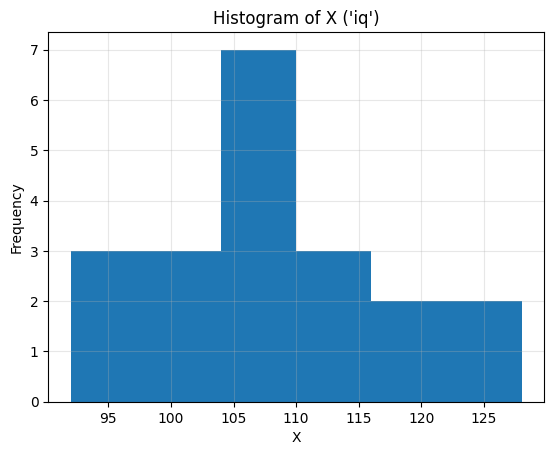

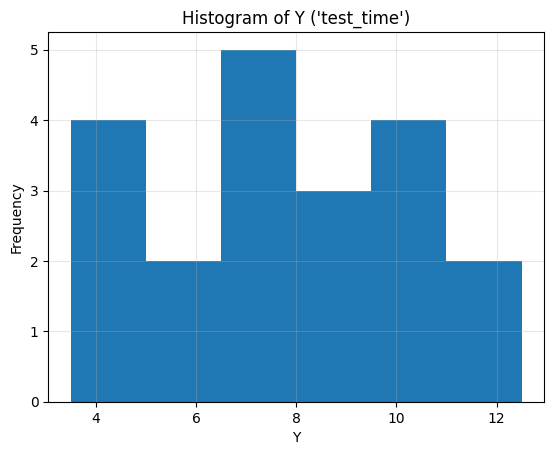

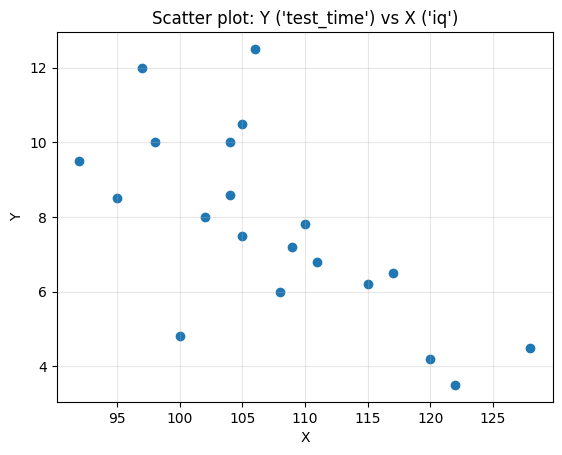

In [26]:
plt.figure()
plt.hist(df_xy["X"].values, bins="auto")
plt.title(f"Histogram of X ('{colname_x}')")
plt.xlabel("X")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.hist(df_xy["Y"].values, bins="auto")
plt.title(f"Histogram of Y ('{colname_y}')")
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.scatter(df_xy["X"].values, df_xy["Y"].values)
plt.title(f"Scatter plot: Y ('{colname_y}') vs X ('{colname_x}')")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
def fit_linear(x, y):
    # y = w1 * x + w0
    X_design = np.c_[np.ones_like(x), x]
    w, *_ = np.linalg.lstsq(X_design, y, rcond=None)
    w0, w1 = w
    def predict(xnew):
        return w0 + w1 * xnew
    return (w0, w1), predict

def fit_quadratic(x, y):
    # y = w2 * x^2 + w1 * x + w0
    X_design = np.c_[np.ones_like(x), x, x**2]
    w, *_ = np.linalg.lstsq(X_design, y, rcond=None)
    w0, w1, w2 = w
    def predict(xnew):
        return w0 + w1 * xnew + w2 * (xnew**2)
    return (w0, w1, w2), predict

def fit_hyperbolic(x, y):
    # y = w1 / x + w0  →  y = w1 * (1/x) + w0
    mask = np.abs(x) > 1e-12  # exclude x ≈ 0
    X = x[mask]
    Y = y[mask]
    U = 1.0 / X
    X_design = np.c_[np.ones_like(U), U]
    w, *_ = np.linalg.lstsq(X_design, Y, rcond=None)
    w0, w1 = w
    def predict(xnew):
        xnew = np.asarray(xnew)
        out = np.full_like(xnew, fill_value=np.nan, dtype=float)
        mask_new = np.abs(xnew) > 1e-12
        out[mask_new] = w0 + w1 / xnew[mask_new]
        return out
    return (w0, w1), predict, mask

def fit_exponential(x, y):
    # y = w0 * (w1^x)  →  ln y = ln w0 + x * ln w1
    mask = y > 0
    X = x[mask]
    Y = y[mask]
    if len(X) < 2:
        # too few y > 0 points
        return None, None, mask
    Yp = np.log(Y)  # linear model for logs
    X_design = np.c_[np.ones_like(X), X]
    w, *_ = np.linalg.lstsq(X_design, Yp, rcond=None)
    a, b = w
    w0 = float(np.exp(a))
    w1 = float(np.exp(b))
    def predict(xnew):
        return w0 * (w1 ** xnew)
    return (w0, w1), predict, mask

def r2_score(y_true, y_pred):
    ss_res = np.nansum((y_true - y_pred)**2)
    ss_tot = np.nansum((y_true - np.nanmean(y_true))**2)
    return 1.0 - ss_res / ss_tot

def f_statistic(R2, n, k):
    """
    F = (R2 / (1 - R2)) * ((n - k) / (k - 1)), where k is the number of model parameters.
    For linear/hyperbolic/exponential k=2, for quadratic k=3.
    """
    if R2 >= 1.0:
        return np.inf
    return (R2 / max(1e-15, (1 - R2))) * ((n - k) / (k - 1))

In [28]:
X = df_xy["X"].values.astype(float)
Y = df_xy["Y"].values.astype(float)
n = len(X)

x_line = np.linspace(np.nanmin(X), np.nanmax(X), 400)

results = {}

(w0_lin, w1_lin), pred_lin = fit_linear(X, Y)
yhat_lin = pred_lin(X)
R2_lin = r2_score(Y, yhat_lin)
F_lin = f_statistic(R2_lin, n, k=2)
results["Linear"] = {"w": (w0_lin, w1_lin), "R2": R2_lin, "F": F_lin, "pred_fun": pred_lin}

(w0_q, w1_q, w2_q), pred_quad = fit_quadratic(X, Y)
yhat_quad = pred_quad(X)
R2_quad = r2_score(Y, yhat_quad)
F_quad = f_statistic(R2_quad, n, k=3)
results["Quadratic"] = {"w": (w0_q, w1_q, w2_q), "R2": R2_quad, "F": F_quad, "pred_fun": pred_quad}

# Hyperbolic
(w0_hyp, w1_hyp), pred_hyp, mask_hyp = fit_hyperbolic(X, Y)
yhat_hyp = pred_hyp(X)
R2_hyp = r2_score(Y[mask_hyp], yhat_hyp[mask_hyp])
F_hyp = f_statistic(R2_hyp, mask_hyp.sum(), k=2)  # n decreases due to mask
results["Hyperbolic"] = {"w": (w0_hyp, w1_hyp), "R2": R2_hyp, "F": F_hyp, "pred_fun": pred_hyp, "mask": mask_hyp}

exp_fit = fit_exponential(X, Y)
if exp_fit[0] is not None:
    (w0_exp, w1_exp), pred_exp, mask_exp = exp_fit
    yhat_exp = pred_exp(X[mask_exp])
    R2_exp = r2_score(Y[mask_exp], yhat_exp)
    F_exp = f_statistic(R2_exp, mask_exp.sum(), k=2)
    results["Exponential"] = {"w": (w0_exp, w1_exp), "R2": R2_exp, "F": F_exp, "pred_fun": pred_exp, "mask": mask_exp}
else:
    results["Exponential"] = {"w": None, "R2": np.nan, "F": np.nan, "pred_fun": None, "mask": None}

summary = pd.DataFrame({
    "Model": list(results.keys()),
    "Parameters": [res["w"] for res in results.values()],
    "R2": [res["R2"] for res in results.values()],
    "F": [res["F"] for res in results.values()],
})
display(summary.sort_values("R2", ascending=False).reset_index(drop=True))

,Model,Parameters,R2,F
0,Quadratic,"(-11.882655892554691, 0.5395941775875409, -0.0...",0.482521,7.925773
1,Linear,"(27.396087786259535, -0.1831106870229007)",0.464870,15.636685
2,Hyperbolic,"(-11.88594407966812, 2091.8740459951414)",0.440972,14.198746
3,Exponential,"(130.8013618684795, 0.9735066346535939)",0.417448,12.898540


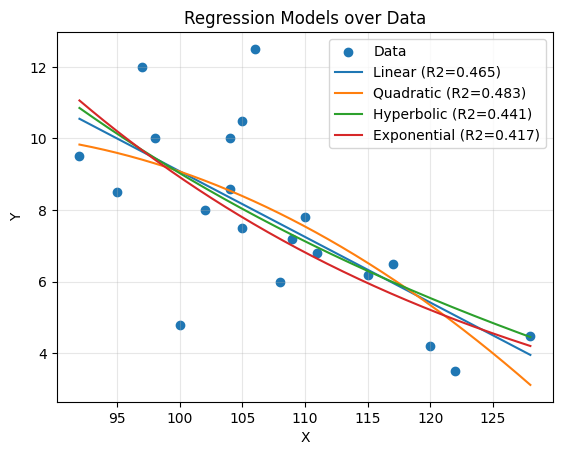

In [29]:
plt.figure()
plt.scatter(X, Y, label="Data")

# Linear
plt.plot(x_line, results["Linear"]["pred_fun"](x_line), label=f"Linear (R2={results['Linear']['R2']:.3f})")

# Quadratic
plt.plot(x_line, results["Quadratic"]["pred_fun"](x_line), label=f"Quadratic (R2={results['Quadratic']['R2']:.3f})")

# Hyperbolic: avoid x≈0
x_line_h = x_line[np.abs(x_line) > 1e-12]
plt.plot(x_line_h, results["Hyperbolic"]["pred_fun"](x_line_h), label=f"Hyperbolic (R2={results['Hyperbolic']['R2']:.3f})")

# Exponential (if successfully estimated)
if results["Exponential"]["w"] is not None:
    plt.plot(x_line, results["Exponential"]["pred_fun"](x_line), label=f"Exponential (R2={results['Exponential']['R2']:.3f})")

plt.title("Regression Models over Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
valid_models = {name: res for name, res in results.items() if not np.isnan(res["R2"])}

best_name = max(valid_models, key=lambda k: valid_models[k]["R2"])
worst_name = min(valid_models, key=lambda k: valid_models[k]["R2"])

def model_df(name: str):
    # Number of parameters
    k = 3 if name == "Quadratic" else 2
    # Effective n (considering masks):
    if name in ["Hyperbolic", "Exponential"] and "mask" in results[name] and results[name]["mask"] is not None:
        n_eff = int(results[name]["mask"].sum())
    else:
        n_eff = n
    return k, n_eff

report_rows = []
for name in [best_name, worst_name]:
    R2 = results[name]["R2"]
    F = results[name]["F"]
    k, n_eff = model_df(name)
    df1 = k - 1
    df2 = n_eff - k
    row = {"Model": name, "R2": R2, "F": F, "df1": df1, "df2": df2}
    # Try to calculate p-value and critical F using SciPy
    F_crit = st.f.ppf(1 - 0.05, df1, df2)
    row.update({"p_value": None, "F_crit(0.05)": None, "Decision (α=0.05)": "Significant" if F > F_crit else "Not significant"})
    report_rows.append(row)

report = pd.DataFrame(report_rows)
display(report)
print(f"Best model by R2: {best_name}")
print(f"Worst model by R2: {worst_name}")

,Model,R2,F,df1,df2,p_value,F_crit(0.05),Decision (α=0.05)
0,Quadratic,0.482521,7.925773,2,17,None,None,Compare F to the tabulated F_crit
1,Exponential,0.417448,12.898540,1,18,None,None,Compare F to the tabulated F_crit


Best model by R2: Quadratic
Worst model by R2: Exponential


# Отчёт по результатам

## 1) Корреляции
- **Фехнера:** \(K = -0.7000\) (диапазон \([-1, 1]\)).
- **Пирсона:** \(r = -0.6818\), \(df = 18\), 95% ДИ = \([-0.8637;\,-0.3427]\).
- **Спирмена:** \(K = -0.6823\).
- **Кендалла:** \(K = -0.5158\).

## 2) Визуализация
Построены гистограммы **X** и **Y**, а также график рассеяния **Y** от **X**.

## 3) Уравнения регрессии (МНК)

> Формы моделей:  
> — Линейная: \(y = w_1 x + w_0\)  
> — Квадратичная: \(y = w_2 x^2 + w_1 x + w_0\)  
> — Гиперболическая: \(y = \dfrac{w_1}{x} + w_0\)  
> — Показательная: \(y = w_0 \cdot w_1^{\,x}\)

| Модель          | Параметры                                                                                              | \(R^2\)  | \(F\)      |
|-----------------|---------------------------------------------------------------------------------------------------------|---------:|-----------:|
| **Linear**      | \(w_0 = 27.396087786259535\), \(w_1 = -0.1831106870229007\)                                            | 0.4649    | 15.6367    |
| **Quadratic**   | \(w_0 = -11.882655892554691\), \(w_1 = 0.5395941775875409\), \(w_2 = -0.0032998604634246085\)          | 0.4825    | 7.9258     |
| **Hyperbolic**  | \(w_0 = -11.88594407966812\), \(w_1 = 2091.8740459951414\)                                             | 0.4410    | 14.1987    |
| **Exponential** | \(w_0 = 130.8013618684795\), \(w_1 = 0.9735066346535939\)                                              | 0.4174    | 12.8985    |

**Лучшая модель по \(R^2\):** _Quadratic_.  
**Худшая модель по \(R^2\):** _Exponential_.

## 4) Проверка уравнения регрессии (критерий Фишера)
- **Quadratic:** \(F = 7.9258\), \(df = (1, 18)\), \(p-value = 0.0115\) → **значима** при \(alpha = 0.05\).
- **Exponential:** \(F = 12.8985\), \(df = (1, 18)\), \(p-value = 0.0021\) → **значима** при \(alpha = 0.05\).

# Выводы по корреляциям

1) **Направление и сила связи**  
   Все четыре коэффициента **отрицательные**:  
   — Фехнера: \(K = -0.70\)  
   — Пирсона: \(r = -0.6818\)  
   — Спирмена: \(K = -0.6823\)  
   — Кендалла: \(K = -0.5158\)  
   Это указывает на **устойчивую обратную связь**: при росте \(X\) значение \(Y\) в среднем уменьшается. По модулю — **средняя / близкая к сильной** отрицательная связь.

2) **Статистическая значимость (Пирсон)**  
   95% ДИ для \(r\): \([-0.8637;\,-0.3427]\), не включает ноль (при \(n=20\), \(df=18\)).  
   Следовательно, линейная отрицательная корреляция **статистически значима** при \(alpha = 0.05\).

3) **Монотонность и устойчивость к выбросам**  
   Близость оценок Пирсона (\(-0.6818\)) и Спирмена (\(-0.6823\)) показывает, что связь **монотонно убывающая** и не определяется единичными выбросами. Отрицательное \(\tau\) Кендалла (\(-0.5158\)) подтверждает это на уровне пар сравнений.

4) **Интерпретация в терминах пар и отклонений**  
   - По **Фехнеру** \(K=-0.70\): примерно **85%** наблюдений имеют **противоположные знаки** отклонений \((X_i-\bar X)\) и \((Y_i-\bar Y)\) *(игнорируя точные равенства среднему)*.  
   - По **Кендаллу** \(K=-0.5158\): около **76%** пар наблюдений **несогласованные** (убывающие), и лишь ~**24%** — согласованные (возрастающие).

5) **Практическое значение**  
   Квадрат корреляции Пирсона: \(r^2 ~ 0.465\). Значит, около **46% вариации \(Y\)** объясняется линейной зависимостью от \(X\); остальная дисперсия — прочие факторы/шум.

6) **Ограничения**  
   Корреляция не равна причинности; возможны скрытые переменные. Тем не менее согласованность **четырёх** мер (знаковая, линейная, ранговые) делает вывод об обратной связи **надёжным** для этих данных.